<a href="https://colab.research.google.com/github/bythyag/xgboost-salespred/blob/main/Store_Sales_Forecasting_with_using_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Generated Data Sample:
                 sales  store_id  on_promotion  is_holiday
date                                                      
2020-01-01  107.450712         1             0           0
2020-01-02  114.522744         1             0           0
2020-01-03  131.133789         1             0           0
2020-01-04  134.402341         1             0           0
2020-01-05   91.647795         1             0           0

Data shape: (3288, 4)


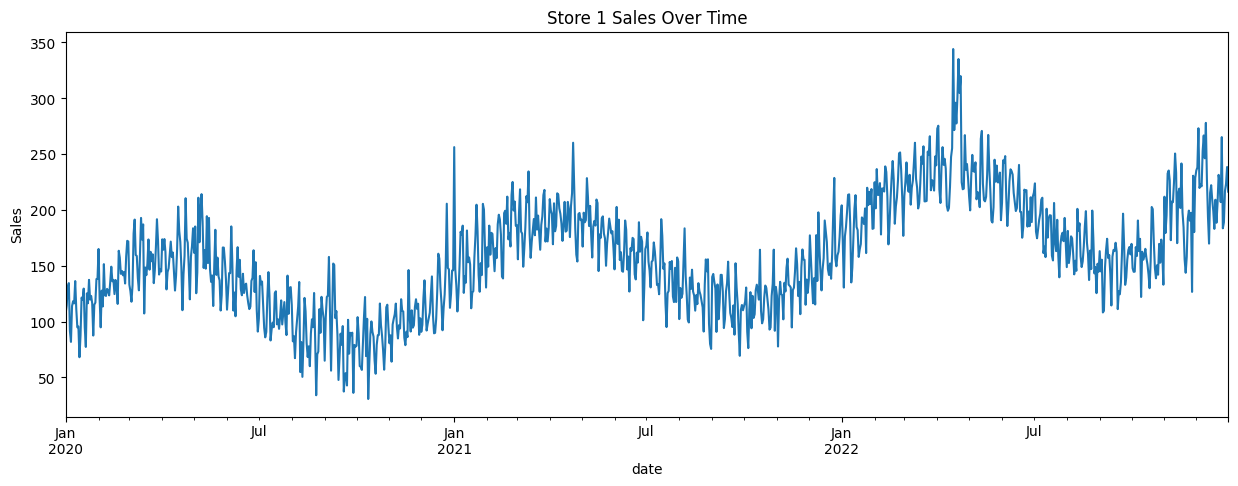

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

# --- Data Generation ---
np.random.seed(42)
n_days = 365 * 3  # 3 years of daily data
n_stores = 3 # Simulate 3 stores

date_rng = pd.date_range(start='2020-01-01', end='2022-12-31', freq='D')
all_store_data = []

for store_id in range(1, n_stores + 1):
    # Base sales with trend and seasonality
    time = np.arange(len(date_rng))
    trend = time * 0.1 * store_id  # Different trend per store
    seasonality_yearly = 50 * store_id * np.sin(2 * np.pi * time / 365.25)
    seasonality_weekly = 20 * store_id * np.sin(2 * np.pi * time / 7)
    noise = np.random.normal(0, 15 * store_id, len(date_rng))
    base_sales = 100 * store_id + trend + seasonality_yearly + seasonality_weekly + noise
    base_sales = np.maximum(base_sales, 10) # Ensure sales are positive

    df = pd.DataFrame({'date': date_rng, 'sales': base_sales})
    df['store_id'] = store_id

    # Exogenous Variables
    # Promotions (randomly assign some promotion periods)
    df['on_promotion'] = 0
    for _ in range(5 * store_id): # More promotions for larger stores
        promo_start = np.random.randint(0, len(df) - 30)
        promo_end = promo_start + np.random.randint(7, 21)
        df.loc[promo_start:promo_end, 'on_promotion'] = 1
        df.loc[promo_start:promo_end, 'sales'] *= np.random.uniform(1.1, 1.5) # Sales boost

    # Holidays (e.g., Christmas, New Year)
    df['is_holiday'] = 0
    holidays = [pd.to_datetime('2020-12-25'), pd.to_datetime('2021-01-01'),
                pd.to_datetime('2021-12-25'), pd.to_datetime('2022-01-01'),
                pd.to_datetime('2022-12-25')]
    for holiday_date in holidays:
        if holiday_date in df['date'].values:
            idx = df[df['date'] == holiday_date].index
            df.loc[idx, 'is_holiday'] = 1
            df.loc[idx, 'sales'] *= np.random.uniform(1.2, 1.8) # Holiday sales boost

    all_store_data.append(df)

data = pd.concat(all_store_data)
data.set_index('date', inplace=True)

print("Generated Data Sample:")
print(data.head())
print(f"\nData shape: {data.shape}")

# Visualize sales for one store
plt.figure(figsize=(15, 5))
data[data['store_id'] == 1]['sales'].plot(title='Store 1 Sales Over Time')
plt.ylabel('Sales')
plt.show()

In [7]:
def create_features(df, target_col='sales', forecast_horizon=7):
    """
    Creates time series features from a datetime index.
    Also creates lag features for the target and exogenous variables.
    """
    df = df.copy()

    # Time-based features
    df['day_of_week'] = df.index.dayofweek
    df['day_of_month'] = df.index.day
    df['day_of_year'] = df.index.dayofyear
    df['week_of_year'] = df.index.isocalendar().week.astype(int)
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['quarter'] = df.index.quarter

    # Cyclical features for time (important for tree models)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['day_of_year_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365.25)
    df['day_of_year_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365.25)
    df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

    # Lag features for target variable
    for lag in range(forecast_horizon, forecast_horizon + 15): # Lags from 7 to 21 days ago
        df[f'{target_col}_lag_{lag}'] = df.groupby('store_id')[target_col].shift(lag)

    # Rolling window statistics for target variable
    for window in [7, 14, 28]:
        df[f'{target_col}_roll_mean_{window}'] = df.groupby('store_id')[target_col].shift(forecast_horizon).rolling(window=window, min_periods=1).mean()
        df[f'{target_col}_roll_std_{window}'] = df.groupby('store_id')[target_col].shift(forecast_horizon).rolling(window=window, min_periods=1).std()
        df[f'{target_col}_roll_min_{window}'] = df.groupby('store_id')[target_col].shift(forecast_horizon).rolling(window=window, min_periods=1).min()
        df[f'{target_col}_roll_max_{window}'] = df.groupby('store_id')[target_col].shift(forecast_horizon).rolling(window=window, min_periods=1).max()

    return df

FORECAST_HORIZON = 7 # Predict next 7 days
data_featured = create_features(data, target_col='sales', forecast_horizon=FORECAST_HORIZON)

data_featured['target_sales'] = data_featured.groupby('store_id')['sales'].shift(-FORECAST_HORIZON)

data_featured = data_featured.dropna()

print("\nData with features:")
print(data_featured.head())
print(f"\nData shape after feature engineering: {data_featured.shape}")


Data with features:
                 sales  store_id  on_promotion  is_holiday  day_of_week  \
date                                                                      
2020-01-22  116.385589         1             0           0            2   
2020-01-23  137.323737         1             0           0            3   
2020-01-24  119.698003         1             0           0            4   
2020-01-25  122.973383         1             0           0            5   
2020-01-26  116.332458         1             0           0            6   

            day_of_month  day_of_year  week_of_year  month  year  ...  \
date                                                              ...   
2020-01-22            22           22             4      1  2020  ...   
2020-01-23            23           23             4      1  2020  ...   
2020-01-24            24           24             4      1  2020  ...   
2020-01-25            25           25             4      1  2020  ...   
2020-01-26     

In [8]:
# Separate features and target
X = data_featured.drop(columns=['sales', 'target_sales']) # 'sales' is original, not to be used as direct feature
y = data_featured['target_sales']

# Temporal split: Train on earlier data, test on later data
# Let's reserve the last 3 months for testing, and 3 months before that for validation
test_cutoff = data_featured.index.max() - pd.DateOffset(months=3)
val_cutoff = test_cutoff - pd.DateOffset(months=3)

X_train = X[X.index < val_cutoff]
y_train = y[y.index < val_cutoff]
X_val = X[(X.index >= val_cutoff) & (X.index < test_cutoff)]
y_val = y[(y.index >= val_cutoff) & (y.index < test_cutoff)]
X_test = X[X.index >= test_cutoff]
y_test = y[y.index >= test_cutoff]

print(f"Train shape: {X_train.shape}, {y_train.shape}")
print(f"Validation shape: {X_val.shape}, {y_val.shape}")
print(f"Test shape: {X_test.shape}, {y_test.shape}")

# Ensure no data leakage from index (though we are using it for splits)
X_train = X_train.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)
# Keep y_test with index for easier plotting later

Train shape: (2652, 43), (2652,)
Validation shape: (276, 43), (276,)
Test shape: (276, 43), (276,)


In [9]:
# Initialize and train the XGBoost Regressor
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',  # For regression
    n_estimators=1000,             # Number of trees
    learning_rate=0.05,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=50
)

print("\nTraining XGBoost model...")

xgb_model.fit(X_train, y_train,
              eval_set=[(X_val, y_val)],
              verbose=100) # Print progress every 100 rounds


Training XGBoost model...
[0]	validation_0-rmse:152.36440
[100]	validation_0-rmse:67.72862
[111]	validation_0-rmse:67.52515


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)


Test Set Evaluation (Predicting 7 days ahead):
RMSE: 50.70
MAE: 38.02
R-squared: 0.89


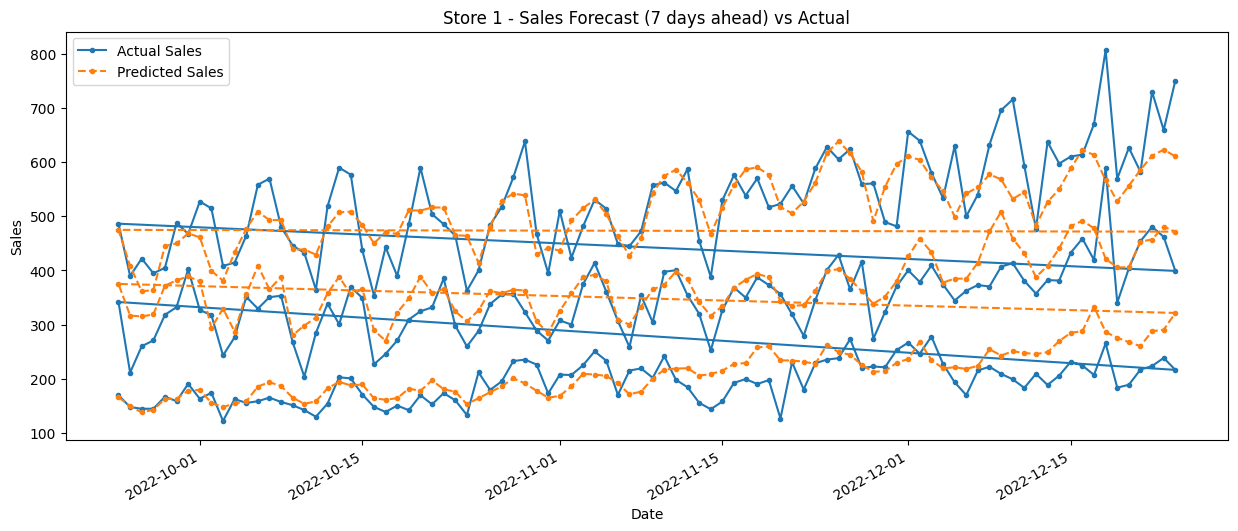

In [10]:
# Make predictions on the test set
y_pred_test = xgb_model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
mae = mean_absolute_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)

print(f"\nTest Set Evaluation (Predicting {FORECAST_HORIZON} days ahead):")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R-squared: {r2:.2f}")

# Combine actuals and predictions for plotting
results_df = pd.DataFrame({'actual_sales': y_test.values, 'predicted_sales': y_pred_test}, index=y_test.index)
results_df = results_df.merge(data[['store_id']], left_index=True, right_index=True, how='left') # Add store_id back

# Plot predictions vs actuals for a specific store
store_to_plot = 1
plt.figure(figsize=(15, 6))
results_df[results_df['store_id'] == store_to_plot]['actual_sales'].plot(label='Actual Sales', style='.-')
results_df[results_df['store_id'] == store_to_plot]['predicted_sales'].plot(label='Predicted Sales', style='.--')
plt.title(f'Store {store_to_plot} - Sales Forecast ({FORECAST_HORIZON} days ahead) vs Actual')
plt.legend()
plt.ylabel('Sales')
plt.xlabel('Date')
plt.show()


Top 20 Feature Importances:
               feature  importance
31   sales_roll_mean_7    0.444252
35  sales_roll_mean_14    0.147636
38   sales_roll_max_14    0.115133
37   sales_roll_min_14    0.096431
39  sales_roll_mean_28    0.030179
16         sales_lag_7    0.026028
42   sales_roll_max_28    0.018652
8                 year    0.012651
10           month_sin    0.011282
15     day_of_week_cos    0.007835
23        sales_lag_14    0.007525
13     day_of_year_cos    0.007244
41   sales_roll_min_28    0.005990
6         week_of_year    0.005763
30        sales_lag_21    0.005181
17         sales_lag_8    0.004872
5          day_of_year    0.004153
40   sales_roll_std_28    0.004058
34    sales_roll_max_7    0.003925
12     day_of_year_sin    0.003617


<ipython-input-11-99093db3acc3>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importances.head(20), palette='viridis')


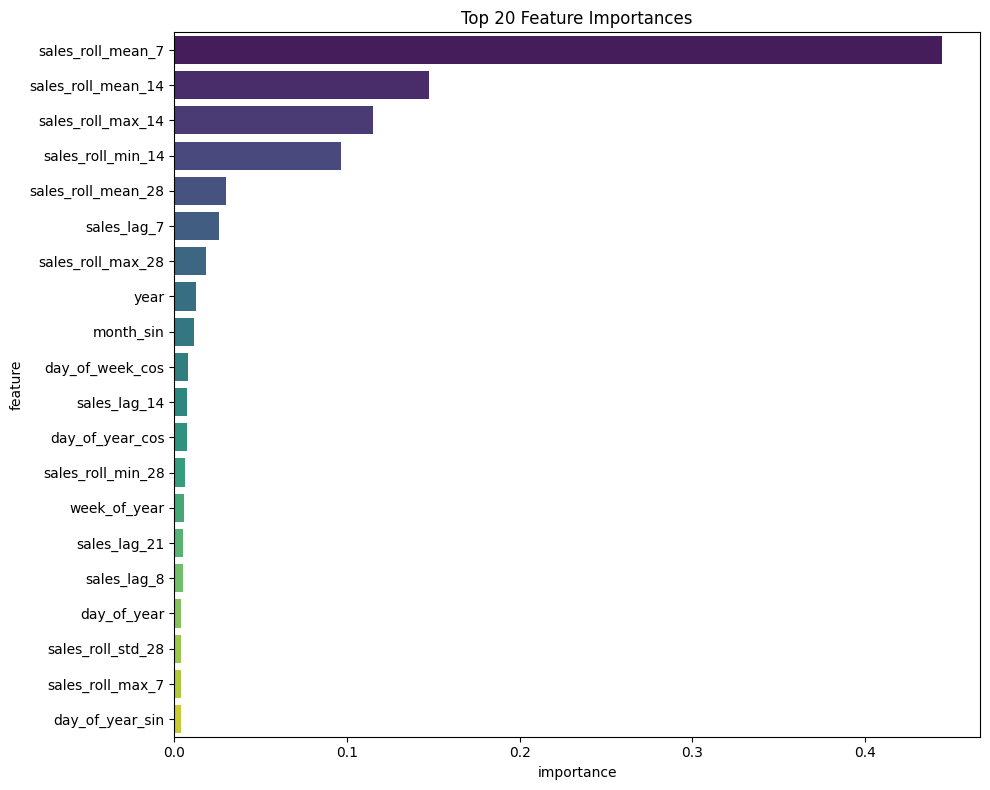

In [11]:
# Get feature importance
feature_importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 20 Feature Importances:")
print(feature_importances.head(20))

plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importances.head(20), palette='viridis')
plt.title('Top 20 Feature Importances')
plt.tight_layout()
plt.show()

In [12]:
print("\nStarting Hyperparameter Tuning (this might take a while)...")
tscv = TimeSeriesSplit(n_splits=3) # Fewer splits for faster demo

param_grid = {
    'n_estimators': [500, 1000],
    'learning_rate': [0.01, 0.05],
    'max_depth': [5, 7, 9],
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.7, 0.8]
}

# We need to combine train and val for CV, then test on the final test set
X_train_val = pd.concat([X_train, X_val])
y_train_val = pd.concat([y_train, y_val])

grid_search = GridSearchCV(
    estimator=xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1),
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_squared_error', # GridSearchCV maximizes, so use negative MSE
    verbose=2
)

grid_search.fit(X_train_val, y_train_val) # Fit on combined train+val

print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best RMSE from CV: {np.sqrt(-grid_search.best_score_):.2f}")

# Retrain with best parameters on the full train+val set
best_xgb_model = grid_search.best_estimator_
# best_xgb_model.fit(X_train_val, y_train_val) # Already fitted by GridSearchCV with refit=True (default)

y_pred_test_tuned = best_xgb_model.predict(X_test)
rmse_tuned = np.sqrt(mean_squared_error(y_test, y_pred_test_tuned))
mae_tuned = mean_absolute_error(y_test, y_pred_test_tuned)
r2_tuned = r2_score(y_test, y_pred_test_tuned)

print(f"\nTest Set Evaluation with Tuned Model ({FORECAST_HORIZON} days ahead):")
print(f"RMSE: {rmse_tuned:.2f}")
print(f"MAE: {mae_tuned:.2f}")
print(f"R-squared: {r2_tuned:.2f}")


Starting Hyperparameter Tuning (this might take a while)...
Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=500, subsample=0.7; total time=   2.2s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=500, subsample=0.7; total time=   1.8s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=500, subsample=0.7; total time=   1.9s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=500, subsample=0.8; total time=   1.8s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=500, subsample=0.8; total time=   1.8s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=500, subsample=0.8; total time=   3.7s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=1000, subsample=0.7; total time=   3.2s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, 